In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from tqdm import tqdm

from mpl_toolkits.basemap import Basemap

#pip install https://github.com/matplotlib/basemap/archive/master.zip

In [100]:
data_path = "../data/AB_NYC_2019.csv"
!wc {data_path}

  49081  384069 7077973 ../data/AB_NYC_2019.csv


In [101]:
df_tmp = pd.read_csv(
    data_path,
    nrows=5
)

columns = list(df_tmp.columns)

print("\nFeatures in dataset:")
for column in columns:
    print(column)

traintypes = {
    'id': 'int32',
    'name': 'str',
    'host_id': 'int32',
    'host_name': 'str',
    'neighbourhood_group': 'str',
    'neighbourhood': 'str',
    'latitude': 'float32',
    'longitude': 'float32',
    'room_type': 'str',
    'price': 'uint16',
    'minimum_nights': 'uint16',
    'number_of_reviews': 'uint16',
    'last_review': 'str',
    'reviews_per_month': 'float16',
    'calculated_host_listings_count': 'uint16',
    'availability_365': 'uint16',
}
cols = list(traintypes.keys())

df_list = []

chunksize = 1_000_000

for df_chunk in tqdm(
    pd.read_csv(
        data_path, 
        dtype=traintypes, 
        chunksize=chunksize
    )
):
    df_chunk['last_review'] = df_chunk['last_review'].str.slice(0, 16)
    df_chunk['last_review'] = pd.to_datetime(df_chunk['last_review'], utc=True, format='%Y-%m-%d %H:%M')
    
    df_list.append(df_chunk)
    
bnb_df = pd.concat(df_list[0:1])
bnb_df = bnb_df[~bnb_df.isin([np.nan, np.inf, -np.inf]).any(1)]

bnb_df = bnb_df[bnb_df["neighbourhood_group"] == "Manhattan"]

del df_list

bnb_df.head()

0it [00:00, ?it/s]


Features in dataset:
id
name
host_id
host_name
neighbourhood_group
neighbourhood
latitude
longitude
room_type
price
minimum_nights
number_of_reviews
last_review
reviews_per_month
calculated_host_listings_count
availability_365


1it [00:00,  4.02it/s]


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.753620,-73.983772,Entire home/apt,225,1,45,2019-05-21 00:00:00+00:00,0.379883,2,355
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.798512,-73.943993,Entire home/apt,80,10,9,2018-11-19 00:00:00+00:00,0.099976,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.747669,-73.974998,Entire home/apt,200,3,74,2019-06-22 00:00:00+00:00,0.589844,1,129
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.764889,-73.984932,Private room,79,2,430,2019-06-24 00:00:00+00:00,3.470703,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.801781,-73.967232,Private room,79,2,118,2017-07-21 00:00:00+00:00,0.990234,1,0


In [102]:
harlem_df = bnb_df[bnb_df["neighbourhood"] == "Harlem"]

harlem_lon = harlem_df["longitude"].values
harlem_lat = harlem_df["latitude"].values

harlem_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
30,9668,front room/double bed,32294,Ssameer Or Trip,Manhattan,Harlem,40.822449,-73.951042,Private room,50,3,242,2019-06-01 00:00:00+00:00,2.039062,3,355
31,9704,Spacious 1 bedroom in luxe building,32045,Teri,Manhattan,Harlem,40.813049,-73.954659,Private room,52,2,88,2019-06-14 00:00:00+00:00,1.419922,1,255
33,9783,back room/bunk beds,32294,Ssameer Or Trip,Manhattan,Harlem,40.821301,-73.953178,Private room,50,3,273,2019-07-01 00:00:00+00:00,2.369141,3,359
44,12343,BEST BET IN HARLEM,47727,Earl,Manhattan,Harlem,40.811749,-73.944778,Entire home/apt,150,7,97,2019-06-13 00:00:00+00:00,0.839844,1,309
81,19159,Spacious luminous apt Upper West NYC,73051,Sybilla,Manhattan,Harlem,40.829151,-73.951363,Entire home/apt,110,31,54,2019-03-23 00:00:00+00:00,0.489990,1,209


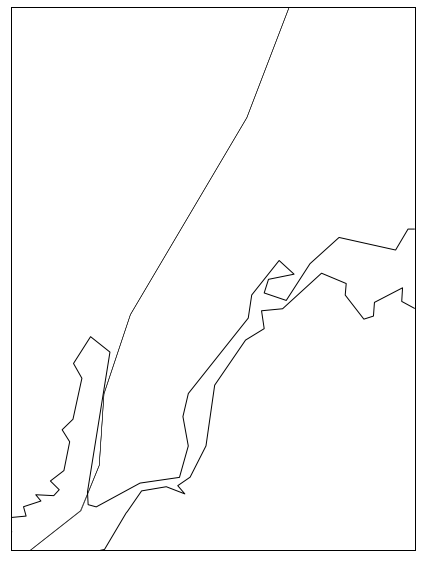

In [103]:
plt.figure(figsize=(20,10))

# https://boundingbox.klokantech.com/
# (latitude, longitude) == (row, col)
bbox_raw = [
    [-74.0551665059,40.6825717946], # lower-left
    [-73.8642790547,40.6825717946], # upper-left
    [-73.8642790547,40.8988332574], # upper-right
    [-74.0551665059,40.8988332574], # lower-right
    [-74.0551665059,40.6825717946]  # lower-left
]

min_lat = min([coord[1] for coord in bbox_raw])
min_lon = min([coord[0] for coord in bbox_raw])

max_lat = max([coord[1] for coord in bbox_raw])
max_lon = max([coord[0] for coord in bbox_raw])

center_lat = min_lat + max_lat / 2
center_lon = min_lon + max_lon / 2

ll_crnr = (min_lat, min_lon)
lr_crnr = (min_lat, max_lon)

ur_crnr = (max_lat, max_lon)
ul_crnr = (max_lat, min_lon)

shape_path = "../data/shapefiles/nyc_neighborhoods.shp"

expansion = 0.0

m = Basemap(
    llcrnrlon=min_lon - expansion,
    llcrnrlat=min_lat - expansion,
    urcrnrlon=max_lon + expansion,
    urcrnrlat=max_lat + expansion,
    projection="mill",
    resolution="h"
    #epsg=2263
)

m.drawmapboundary()
#m.fillcontinents(color='#ddaa66',lake_color='aqua')
m.drawcoastlines()
m.drawstates()
m.drawrivers()

#m.arcgisimage(service='World_Street_Map', xpixels = 3000)

# m.scatter(
#     x=harlem_lon, 
#     y=harlem_lat,
#     alpha=0.2,
    
#     marker='.',

#     latlon=True
# )

m.hexbin(x=harlem_lon, y=harlem_lat, gridsize=1000, bins='log', cmap=cm.YlOrRd_r)

plt.show()

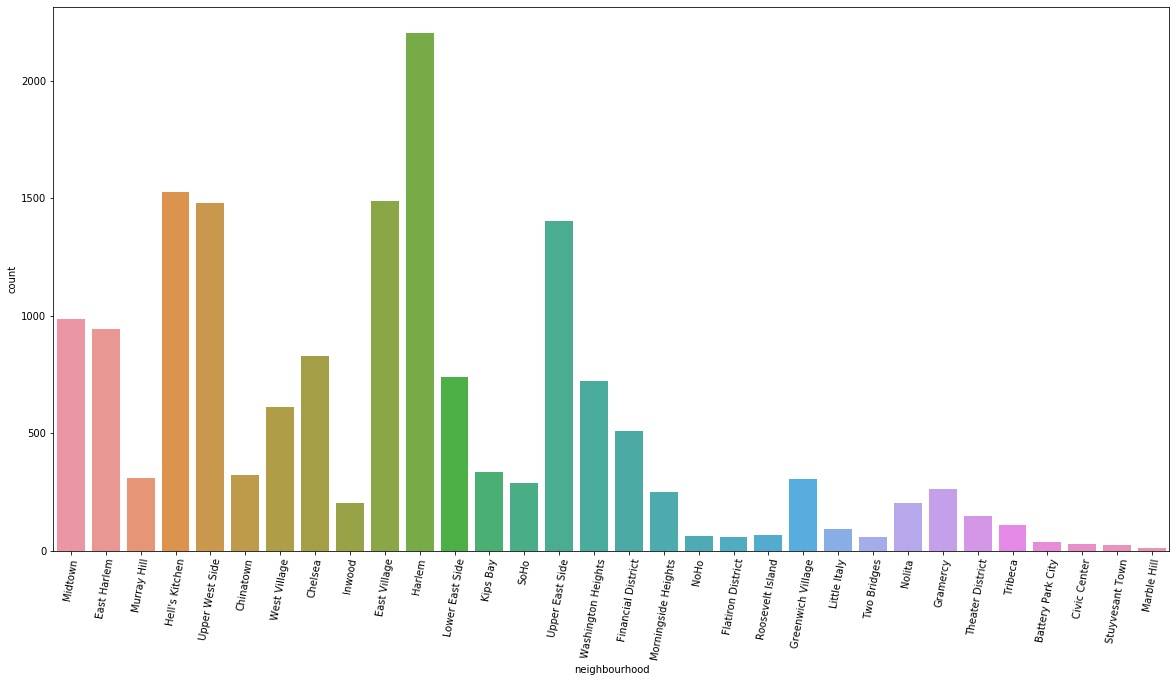

In [104]:
neighbourhoods = bnb_df["neighbourhood"].unique()

plt.figure(figsize=(20,10))
n_plot = sns.countplot(bnb_df["neighbourhood"])
n_plot.set_xticklabels(labels=neighbourhoods, rotation=80)
plt.show()